In [2]:
import pandas as pd
import spacy
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim
import ast
import openpyxl
from gensim.models import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt

In [ ]:
class myconfig():
    jp_data_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/1.DataFrame_JP_all_clean.xlsx"
    kr_data_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/1.DataFrame_KR_all_clean.xlsx"
    stop_words_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/불용어리스트.xlsx"

    all_data_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/3.DataFrame_명사추가.xlsx"
    freq_data_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/3.vocab_freq.xlsx"
    for_wc_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/3.wc용_data.xlsx"
    
    result_excel_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/4.LDA_results_100ep.xlsx"
    result2_excel_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/4. LDA_results_2_100ep.xlsx"
    result_html_path = r"C:/Users/user/Desktop/토픽 모델링/데이터/4.LDA_pyLDAvis_100ep.html"
    
    

mcfg = myconfig()

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
from spacy.lang.en import STOP_WORDS
# 불용어에 추가할 단어
custom_stop_words = list(pd.read_excel(mcfg.stop_words_path)["stopwords"])

# 기존 불용어에 사용자 정의 불용어 추가
for word in custom_stop_words:
    STOP_WORDS.add(word)

# 다시 모델 로드 (불용어가 추가된 상태)
nlp = spacy.load("en_core_web_sm")

In [5]:
df_all = pd.read_excel(mcfg.all_data_path, index_col=0)

In [6]:
# 명사 추출 및 단.복수 통일 / 불용어 버리기
def extract_nouns_and_lemmas(text):   
    doc = nlp(text)
    nouns_and_lemmas = []
    
    for token in doc:
        if token.pos_ == 'NOUN':
            token = token.lemma_
            if nlp.vocab[token].is_stop == False:
                if len(token) >= 3:
                    nouns_and_lemmas.append(str(token))

    return nouns_and_lemmas

In [7]:
abstract_noun = []

for text in df_all["Abstract"]:
    nouns = extract_nouns_and_lemmas(text)
    abstract_noun.append(nouns)

len(abstract_noun)

1476

In [8]:
df_all["Abstract_token"] = abstract_noun
tokenized_data = abstract_noun

In [9]:
df_all["Abstract"]

0       This study focuses on mini tennis a regional s...
1       The purpose of this study is to investigate th...
2       The theme of this study was made possible by c...
3       The purpose of this two year symposium is to e...
4       Lifelong sports have conceptual dimensions tha...
                              ...                        
1471    The purposes of the study was to identify the ...
1472    The purpose of this study was to investigate t...
1473    The goal of this paper is to deal with the rol...
1474    The purpose of this study is conducted to fact...
1475    This study shows the relationship between demo...
Name: Abstract, Length: 1476, dtype: object

In [10]:
df_all["Title"][1195]

'직장인의 생활체육 참여에 따른 심리적 행복감이 생활만족과 직무만족에 미치는 영향'

## 필요 변수 생성

In [11]:
# 추출 단어 확인(5개 이상)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(tokenizer=extract_nouns_and_lemmas , min_df=5)
dtm = cv.fit_transform(df_all["Abstract"])

c:\Users\user\anaconda3\envs\PY39_\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# 단어 빈도 데이터 프레임
word_count = pd.DataFrame({
    'word': cv.get_feature_names_out(),
    'count': dtm.sum(axis=0).flat
})

word_count_desc = word_count.sort_values('count', ascending=False)

In [13]:
dictionary = corpora.Dictionary(tokenized_data)
id2word = Dictionary(tokenized_data)
corpus = [id2word.doc2bow(text) for text in tokenized_data]

# corpus = Sparse2Corpus(dtm.T)
# words = cv.get_feature_names_out().tolist()
# id2word = dict(enumerate(words))
# tokenized_data = df_all["Abstract_token"].apply(ast.literal_eval).tolist()

In [14]:
# 0번 문서의 단어 수
# corpus[0]

## LDA

In [ ]:
# coherence_values = []
# num_topics_range = list(range(5,16))

# for num_topics in num_topics_range:

#     lda_model = LdaModel(
#         corpus=corpus,
#         id2word=id2word,
#         num_topics=num_topics,
#         random_state=100,
#         update_every=1,
#         chunksize=100,
#         passes=100,
#         iterations=100,
#         alpha='auto',
#         eta='auto',
#         per_word_topics=True)

#     coherence_model = CoherenceModel(model=lda_model, texts=df_all["Abstract_token"], dictionary=id2word, coherence='c_v')

#     # Get the coherence score
#     coherence_score = coherence_model.get_coherence()
#     coherence_values.append(coherence_score)

In [16]:
perplexity_values = []
num_topics_range = list(range(5,21))

for num_topics in num_topics_range:

    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        iterations=100,
        alpha='auto',
        eta='auto',
        per_word_topics=True)
    
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_values.append(perplexity)

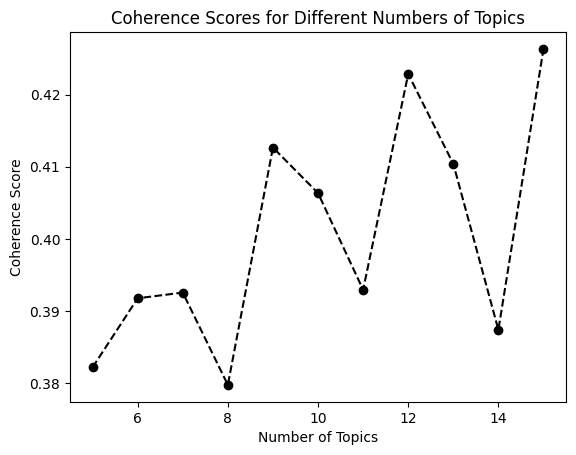

In [20]:
plt.plot(num_topics_range, coherence_values, marker='o', linestyle='--', color='black')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores for Different Numbers of Topics')
# plt.grid(True)
plt.show()

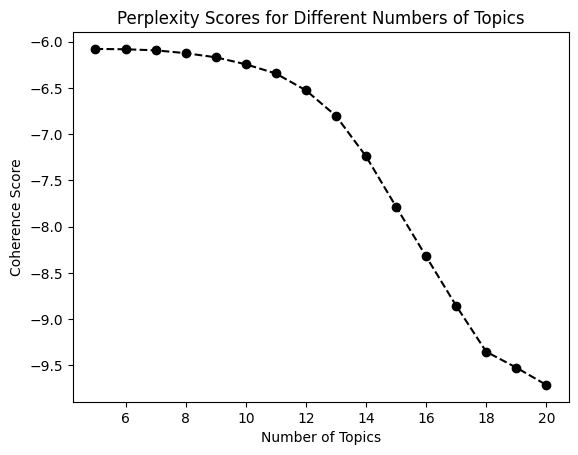

In [18]:
plt.plot(num_topics_range, perplexity_values, marker='o', linestyle='--', color='black')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Perplexity Scores for Different Numbers of Topics')
# plt.grid(True)
plt.show()

In [21]:
max_index = coherence_values.index(max(coherence_values))
num_topics = num_topics_range[max_index]
num_topics

15

In [22]:
num_topics = 9

In [23]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=100,
    iterations=100,
    alpha='auto',
    eta='auto',
    per_word_topics=True)


## LDA 결과 저장

In [68]:
# 단어가 어떤 토픽에 포함되어 있는지 확인
# word_idx = words.index('sport')
# lda_model.get_term_topics(word_idx)

In [24]:
# 문서 별 토픽 분포
doc_idx = 0
lda_model.get_document_topics(corpus[doc_idx])

[(0, 0.026772946),
 (1, 0.16551518),
 (2, 0.35227063),
 (4, 0.28261358),
 (5, 0.04759784),
 (8, 0.102201246)]

In [25]:
# 토픽 별 중요단어 상위 50개 저장
num_topics = lda_model.num_topics

df_topics = pd.DataFrame()

for topic_id in range(num_topics):
    topic_words = lda_model.show_topic(topic_id, topn=50)
    
    df_topic = pd.DataFrame(topic_words, columns=[f'Topic_{topic_id+1}_Word', f'Topic_{topic_id+1}_Prob'])
    
    df_topics = pd.concat([df_topics, df_topic], axis=1)

In [26]:
# 문서 별 토픽 분포 저장
data = []
num_topics = lda_model.num_topics

for document_index, document in enumerate(corpus):
    
    doc_topics = lda_model.get_document_topics(document, per_word_topics=False)
    
    topic_weights = {f'Topic_{topic+1}': weight for topic, weight in doc_topics}
    topic_weights['Document Index'] = document_index
    data.append(topic_weights)

df_document_topics_all = pd.DataFrame(data)

column_order = ['Document Index'] + [f'Topic_{i+1}' for i in range(num_topics)]
df_document_topics_all = df_document_topics_all[column_order]

df_document_topics_all['Sum'] = df_document_topics_all.iloc[:, 1:].sum(axis=1)

df_document_topics_all.fillna(0, inplace=True)

# Set display precision for floating-point numbers to 4
pd.set_option('display.float_format', '{:.4f}'.format)

In [27]:
df_document_topics_all["Country"] = "Japan"
df_document_topics_all.loc[1195:, "Country"] = "Korea"

# Insert "Country" column at the beginning of the DataFrame
df_document_topics_all.insert(0, "Country", df_document_topics_all.pop("Country"))

In [28]:
df_japan = df_document_topics_all[df_document_topics_all["Country"] == "Japan"]
df_Korea = df_document_topics_all[df_document_topics_all["Country"] == "Korea"]

In [29]:
with pd.ExcelWriter(mcfg.result_excel_path, engine='openpyxl') as excel_writer:
    df_topics.to_excel(excel_writer, sheet_name='토픽 별 중요단어', index=False)
    df_document_topics_all.to_excel(excel_writer, sheet_name='문서 별 토픽 분포', index=False)
    df_japan.to_excel(excel_writer, sheet_name='나라 별 토픽 분포_일본', index=False)
    df_Korea.to_excel(excel_writer, sheet_name='나라 별 토픽 분포_한국', index=False)


## 평가

In [30]:
lda_model.log_perplexity(corpus)
 #0에가까울수록 성능 높음

-6.082422781415614

In [31]:
topn = 25
top_words = set()

for topic in range(lda_model.num_topics):
    for word, prob in lda_model.show_topic(topic, topn=topn):
        top_words.add(word)

len(top_words) / (lda_model.num_topics * topn)

#1에가까울수록 성능 높음

0.9155555555555556

In [32]:
dic = Dictionary()
dic.id2token = id2word
dic.token2id = {w: i for i, w in id2word.items()}

In [33]:
p = pyLDAvis.gensim.prepare(
    lda_model, corpus, dic, sort_topics=False)
pyLDAvis.display(p)

In [34]:
pyLDAvis.save_html(p, mcfg.result_html_path)

In [35]:
data = []
for i, doc_bow in enumerate(corpus):
    row = {'Document': f'Document {i}'}
    for word_id, frequency in doc_bow:
        word = dictionary[word_id]
        row[word] = frequency
    data.append(row)

df_words = pd.DataFrame(data).fillna(0).set_index('Document').astype(int)

In [36]:
with pd.ExcelWriter(mcfg.result2_excel_path, engine='openpyxl') as excel_writer:
    df_words.to_excel(excel_writer, sheet_name='words_100ep', index=True)